In [1]:
from os import path

PROJECT_ROOT = path.abspath(path.join(globals()['_dh'][0], '..'))
DATALAKE_PATH = path.abspath(path.join(PROJECT_ROOT, '..', '..', 'datalake', 'mlpbertproj'))
FQFN_PROCESSED_DF = path.join(DATALAKE_PATH, 'processed', f'processed_20250205.jsonl')
MODEL_DIR = path.abspath(path.join(PROJECT_ROOT, 'mlpbertproj', 'classifier'))

In [2]:
import matplotlib.pyplot as plt
import traceback
import pandas as pd

df_unified = pd.read_json(f'file://{FQFN_PROCESSED_DF}', orient='records', lines=True)
print(f'df shape={df_unified.shape}')
print(f'df columns={df_unified.columns}')

df shape=(699, 5)
df columns=Index(['file_name', 'fqfn', 'text_body', 'text_embeddings', 'label'], dtype='object')


In [3]:
print('Before deduplication')
print(f'shape={df_unified.shape}')
df_dedup = df_unified.drop_duplicates(subset='text_body')
print('After deduplication')
print(f'shape={df_dedup.shape}')

Before deduplication
shape=(699, 5)
After deduplication
shape=(566, 5)


In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
print(f'dimensionality of embedding = {len(df_dedup.iloc[3]["text_embeddings"])}')

dimensionality of embedding = 768


In [6]:
embeddings_array = df_dedup['text_embeddings'].to_numpy()
print(f'text embeddings shape={embeddings_array.shape}')

text embeddings shape=(566,)


In [7]:
METRICS = ['chebyshev', 'minkowski']  # 'chebyshev', 'manhattan', 'hamming'
UMAP_PARAMS = [(25, 0.15, 15, 30, 0.2), (25, 0.15, 20, 35, 0.2), (25, 0.15, 15, 55, 0.2)]  # (20, 0.1, 10, 10, 0.1),

In [ ]:
from tqdm.auto import tqdm
from utils.hdbscan_clustering import plot_2d, clusterer

# figsize = (width, height)
fig, axes = plt.subplots(nrows=len(METRICS), ncols=len(UMAP_PARAMS), figsize=(len(UMAP_PARAMS) * 5, len(METRICS) * 5))

for i, metric in enumerate(tqdm(METRICS, desc='metrics')):
    for j, (umap_n_neighbors, umap_min_dist, cluster_min_size, cluster_min_samples, cluster_selection_epsilon) in enumerate(tqdm(UMAP_PARAMS, desc='umap params', leave=False)):

        try:
            hdb, coverage, dbcv = clusterer(
                embeddings_array,
                umap_n_neighbors=umap_n_neighbors,
                umap_min_dist=umap_min_dist,
                umap_metric=metric,
                umap_n_component=2,
                umap_use_random_state=True,
                cluster_selection_method='eom',
                cluster_min_size=cluster_min_size,
                cluster_min_samples=cluster_min_samples,
                cluster_selection_epsilon=cluster_selection_epsilon
            )

            plot_2d(
                hdb._raw_data, hdb.labels_, hdb.probabilities_, ax=axes[i][j] if len(METRICS) > 1 else axes[j],
                parameters={
                    'metric': metric, 'min_cluster_size': cluster_min_size, 'eps': cluster_selection_epsilon,
                    'dbcv': f'{dbcv:.2f}', 'coverage': f'{coverage:.2f}'
                }
            )
        except Exception as e:
            traceback.print_exc()


In [ ]:
from utils.hdbscan_clustering import plot_3d

# figsize = (width, height)
fig, axes = plt.subplots(nrows=len(METRICS), ncols=len(UMAP_PARAMS), figsize=(len(UMAP_PARAMS) * 5, len(METRICS) * 5),
                         subplot_kw=dict(projection='3d'))

for i, metric in enumerate(tqdm(METRICS, desc='metrics')):
    for j, (umap_n_neighbors, umap_min_dist, cluster_min_size, cluster_min_samples, cluster_selection_epsilon) in enumerate(tqdm(UMAP_PARAMS, desc='umap params', leave=False)):

        try:
            hdb, coverage, dbcv = clusterer(
                embeddings_array,
                umap_n_neighbors=umap_n_neighbors,
                umap_min_dist=umap_min_dist,
                umap_metric=metric,
                umap_n_component=3,
                umap_use_random_state=True,
                cluster_selection_method='eom',
                cluster_min_size=cluster_min_size,
                cluster_min_samples=cluster_min_samples,
                cluster_selection_epsilon=cluster_selection_epsilon
            )

            plot_3d(
                hdb._raw_data, hdb.labels_, hdb.probabilities_, ax=axes[i][j],
                parameters={
                    'metric': metric, 'min_cluster_size': cluster_min_size, 'eps': cluster_selection_epsilon,
                    'dbcv': f'{dbcv:.2f}', 'coverage': f'{coverage:.2f}'
                }
            )
        except Exception as e:
            traceback.print_exc()

In [ ]:
COMPONENTS = [3, 5, 7]
fig, axes = plt.subplots(nrows=1, ncols=len(COMPONENTS), figsize=(len(COMPONENTS) * 5, 5),
                         subplot_kw=dict(projection='3d'))
metric = 'minkowski'
umap_n_neighbors, umap_min_dist, cluster_min_size, cluster_min_samples, cluster_selection_epsilon = (25, 0.15, 20, 35, 0.2)

for idx, n_component in enumerate(tqdm(COMPONENTS, desc='components')):
    try:
        hdb, coverage, dbcv = clusterer(
            embeddings_array,
            umap_n_neighbors=umap_n_neighbors,
            umap_min_dist=umap_min_dist,
            umap_metric=metric,
            umap_n_component=n_component,
            umap_use_random_state=True,
            cluster_selection_method='eom',
            cluster_min_size=cluster_min_size,
            cluster_min_samples=cluster_min_samples,
            cluster_selection_epsilon=cluster_selection_epsilon
        )

        plot_3d(
            hdb._raw_data, hdb.labels_, hdb.probabilities_, ax=axes[idx],
            parameters={
                'metric': metric, 'min_cluster_size': cluster_min_size, 'eps': cluster_selection_epsilon,
                'dbcv': f'{dbcv:.2f}', 'coverage': f'{coverage:.2f}', 'n_component': n_component
            }
        )
    except Exception as e:
        traceback.print_exc()

/Users/shershen/virtualenvs/tensor_craft/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


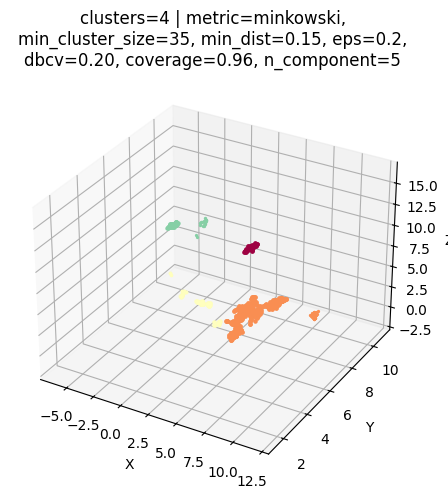

In [11]:
n_component = 5
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), subplot_kw=dict(projection='3d'))
metric = 'minkowski'
umap_n_neighbors, umap_min_dist, cluster_min_size, cluster_min_samples, cluster_selection_epsilon  = (25, 0.15, 20, 35, 0.2)

try:
    hdb, coverage, dbcv = clusterer(
        embeddings_array,
        umap_n_neighbors=umap_n_neighbors,
        umap_min_dist=umap_min_dist,
        umap_metric=metric,
        umap_n_component=n_component,
        umap_use_random_state=False,
        cluster_selection_method='eom',
        cluster_min_size=cluster_min_size,
        cluster_min_samples=cluster_min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon
    )

    plot_3d(
        hdb._raw_data, hdb.labels_, hdb.probabilities_, ax=axes,
        parameters={
            'metric': metric, 'min_cluster_size': cluster_min_samples, 'min_dist': umap_min_dist,
            'eps': cluster_selection_epsilon, 'dbcv': f'{dbcv:.2f}', 'coverage': f'{coverage:.2f}',
            'n_component': n_component
        }
    )
except Exception as e:
    traceback.print_exc()

In [12]:
df_dedup['cluster_id'] = hdb.labels_


/var/folders/26/xmrnj2c94q9gpr7g8g9c6w9h0000gn/T/ipykernel_28046/207482245.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup['cluster_id'] = hdb.labels_


In [13]:
from os import path
from datetime import datetime

formatted_date = datetime.now().strftime('%Y%m%d')
fqfn_text_bodies = path.join(DATALAKE_PATH, 'processed', f'processed_with_cluster_labels_{formatted_date}.jsonl')
df_dedup.to_json(fqfn_text_bodies, orient='records', lines=True)

In [14]:
# import pandas as pd
# 
# fqfn_text_bodies = path.join(DATALAKE_PATH, 'processed', f'processed_with_cluster_labels_20250205.records')
# df_dedup = pd.read_json(fqfn_text_bodies, orient='records', lines=True)
# df_dedup.shape

In [ ]:
from utils.hdbscan_clustering import draw_cat_histogram

cluster_counts = draw_cat_histogram(df_dedup['cluster_id'], title='Number of records per cluster', limit=50)
print(f'Total number of records = {df_dedup.shape[0]}')

In [ ]:
cluster_counts.sort_values(ascending=False, inplace=False, ignore_index=False)[:50]
